In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")
data = data.sample(n=10000, random_state=42)

In [3]:
data.head()

,smiles,logP,qed,SAS
100329,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...,1.13960,0.793487,3.843395
12103,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...,0.34360,0.784932,4.232355
170922,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n,4.85712,0.569373,3.463493
106167,C=CCc1ccccc1OC(C)=O\n,2.34040,0.401613,1.943724
33917,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...,4.10500,0.843003,2.639230


In [4]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [5]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [6]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [7]:
data['mol'] = data['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [8]:
data['mol_sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

In [9]:
mol2vec = [DfVec(x) for x in sentences2vec(data['mol_sentence'], model, unseen='UNK')]

In [10]:
mol2vec = np.array([x.vec for x in mol2vec])

In [11]:
mol2vec.shape

(10000, 300)

In [12]:
split= {f'vec_{i}': mol2vec[:, i] for i in range(mol2vec.shape[1])}

In [13]:
vecs = pd.DataFrame(split)

In [14]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,-0.595844,13.599172,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,1.148437,14.245388,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,0.347149,9.091203,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,-0.307675,6.528207,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,1.239658,12.163701,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615


In [15]:
vecs['logP'] = data['logP'].values
vecs['smiles'] = data['smiles'].values

In [16]:
vecs

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.149517,-5.912338,-3.342572,5.063833,1.209950,1.450080,-8.835844,-2.422362,3.261962,0.181602,...,8.066936,-5.068615,-5.878430,-4.655751,-5.748816,-2.033437,-10.135429,-1.273553,2.95734,Cc1cc(NC(=O)c2cc(C3CC3)nc3onc(C)c23)on1\n
9996,0.866559,-5.617601,-2.084500,1.500934,0.414463,-0.230240,-11.030504,-1.679072,6.781714,0.316821,...,7.834716,0.742749,-9.184113,-3.480695,-4.664177,-6.158488,-10.926046,-3.834805,2.14680,CCCCNC(=O)c1ccc(CNC(=O)N2CCO[C@H](C)C2)cc1\n
9997,1.767921,-5.417960,-2.414780,5.429947,-0.234058,-2.773077,-10.402782,-2.301766,6.844529,4.105608,...,6.886694,-1.467427,-7.947645,-4.368306,-7.309598,-5.828468,-11.302728,-1.049029,3.84539,COc1ccc(-c2n[nH]c(=S)n2CC(=O)NC2CCCCCCC2)cc1\n
9998,0.796060,-5.421035,-0.334348,4.779342,-1.001768,-1.208561,-8.081294,-1.126442,9.446869,2.685735,...,9.897014,-0.473376,-6.800110,-1.895076,-5.264774,-3.981951,-8.188497,-1.878498,2.83350,C[C@H]1C[C@H]1NC(=O)NC[C@@H](c1ccc(Cl)cc1)n1cc...


In [17]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [18]:
smiles = Chem.MolFromSmiles("CCCNBr")

In [19]:
print('Molecular sentence:', mol2alt_sentence(smiles, radius=1))
print('\nMolSentence object:', MolSentence(mol2alt_sentence(smiles, radius=1)))
print('\nDfVec object:',DfVec(sentences2vec(MolSentence(mol2alt_sentence(smiles, radius=1)), model, unseen='UNK')))

Molecular sentence: ['2246728737', '3542456614', '2245384272', '1173125914', '2245384272', '787069595', '847961216', '2278910100', '3612926680', '1113379627']

MolSentence object: MolSentence with 10 words

DfVec object: (10, 300) dimensional vector


In [20]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...


In [21]:
# create random 2D data for clustering
from sklearn.datasets import make_blobs
dummy_data = make_blobs(n_samples=50, n_features=2, centers=5, cluster_std=1.5, random_state=42)

In [22]:
# create a dataframe with the data
df = pd.DataFrame(dummy_data[0], columns=['x', 'y'])

In [23]:
df.index = [f'point_{i}' for i in range(len(df))]

In [24]:
from sklearn.neighbors import NearestNeighbors
# create a nearest neighbor object
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(df)

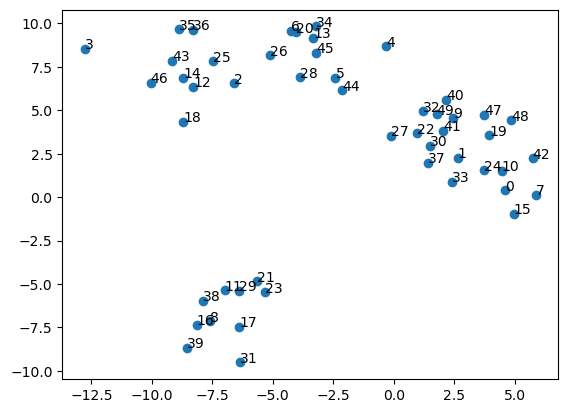

In [25]:
plt.plot(df['x'], df['y'], 'o')
for i in range(len(df)):
    plt.annotate(i, (df['x'][i], df['y'][i]))
plt.show()

In [26]:
point_14 = df.iloc[14]

In [27]:
nbrs_14 = nbrs.kneighbors([point_14])

/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [28]:
nbrs_14

(array([[0.        , 0.66270959, 1.08640794, 1.37730759, 1.55902814]]),
 array([[14, 12, 43, 46, 25]]))

In [29]:
df['neighpors'] = df.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)

/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [30]:
df.head()

,x,y,neighpors
point_0,4.619633,0.386603,"[0, 10, 7, 15, 24]"
point_1,2.647600,2.268462,"[1, 37, 24, 30, 33]"
point_2,-6.621487,6.546118,"[2, 25, 12, 14, 26]"
point_3,-12.767945,8.556377,"[3, 46, 43, 35, 14]"
point_4,-0.310724,8.675622,"[4, 5, 45, 13, 34]"


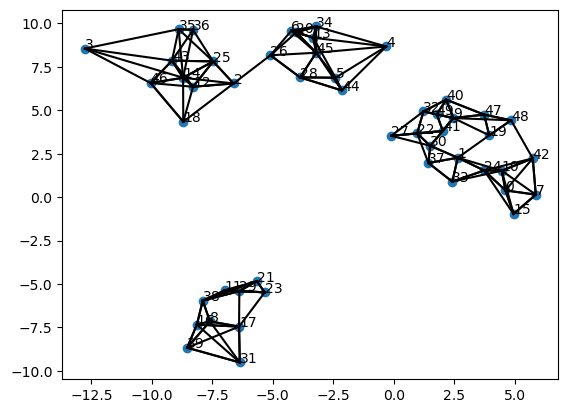

In [31]:
plt.plot(df['x'], df['y'], 'o')
for i in range(len(df)):
    plt.annotate(i, (df['x'][i], df['y'][i]))
    for j in df['neighpors'][i]:
        plt.plot([df['x'][i], df['x'][j]], [df['y'][i], df['y'][j]], 'k-')

In [32]:
# create graph of neighbors
import networkx as nx

In [33]:
G = nx.Graph()

In [34]:
G.add_nodes_from(df.index)

In [35]:
for i in range(len(df)):
    for j in df['neighpors'][i]:
        G.add_edge(df.index[i], df.index[j])

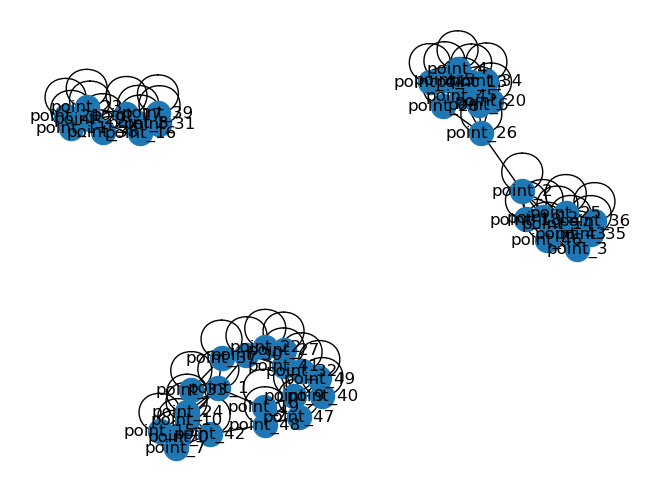

In [36]:
nx.draw(G, with_labels=True)

In [37]:
# is graph connected?
nx.is_connected(G)

False

In [38]:
def graph_from_df(df, neighbors=5, ignore_cols=False):
    # create a nearest neighbor object
    if ignore_cols:
        df = df.drop(ignore_cols, axis=1)
    nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(df)
    # add neighbors to dataframe
    neighbors = df.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)
    # create graph of neighbors
    G = nx.Graph()
    G.add_nodes_from(df.index)
    for i in range(len(df)):
        for j in neighbors[i]:
            G.add_edge(df.index[i], df.index[j])
    return G

In [39]:
df = pd.DataFrame(dummy_data[0], columns=['x', 'y'])

In [40]:
import warnings
warnings.filterwarnings('ignore')
for i in range(20):
    print(f'Graph with {i+1} neighbors is connected: {nx.is_connected(graph_from_df(df, neighbors=i+1))}')
    G = graph_from_df(df, neighbors=i+1)
    if nx.is_connected(G):
        break

Graph with 1 neighbors is connected: False
Graph with 2 neighbors is connected: False
Graph with 3 neighbors is connected: False
Graph with 4 neighbors is connected: False
Graph with 5 neighbors is connected: False
Graph with 6 neighbors is connected: False
Graph with 7 neighbors is connected: False
Graph with 8 neighbors is connected: False
Graph with 9 neighbors is connected: False
Graph with 10 neighbors is connected: False
Graph with 11 neighbors is connected: True


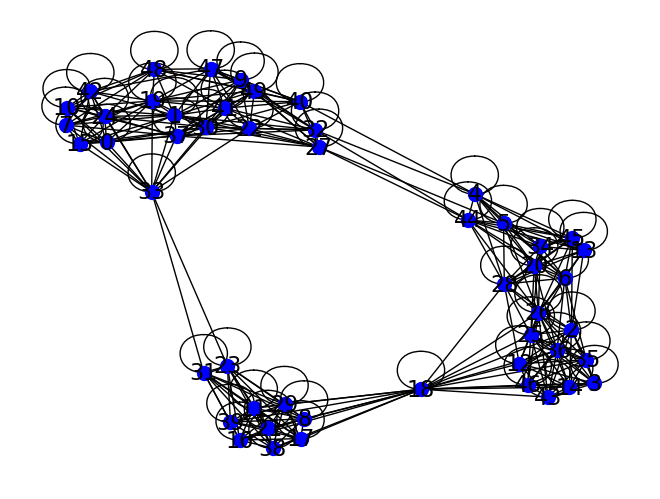

In [41]:
nx.draw(G, with_labels=True, node_color='b', node_size=100, font_size=16)

In [42]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...


In [43]:
G = graph_from_df(vecs, neighbors=5, ignore_cols=['logP', 'smiles'])

In [44]:
nx.is_connected(G)

True

In [45]:
# add neighbors to dataframe
%time
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(vecs.drop(['logP', 'smiles'], axis=1))
test_vecs = vecs.drop(['logP', 'smiles'], axis=1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [46]:
test_vecs['neighbors'] = test_vecs.apply(lambda x: nbrs.kneighbors([x])[1][0], axis=1)

In [47]:
test_vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,neighbors
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,13.599172,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,"[0, 7592, 2508, 8608, 9714]"
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,14.245388,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,"[1, 588, 6776, 71, 7093]"
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,9.091203,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,"[2, 1786, 3148, 4270, 4640]"
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,6.528207,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,"[3, 798, 7048, 1752, 4005]"
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,12.163701,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,"[4, 1621, 1570, 2564, 8931]"


In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(vecs.drop(['logP', 'smiles'], axis=1))
pca_vecs = pca.transform(vecs.drop(['logP', 'smiles'], axis=1))

In [49]:
target = vecs['logP'].values

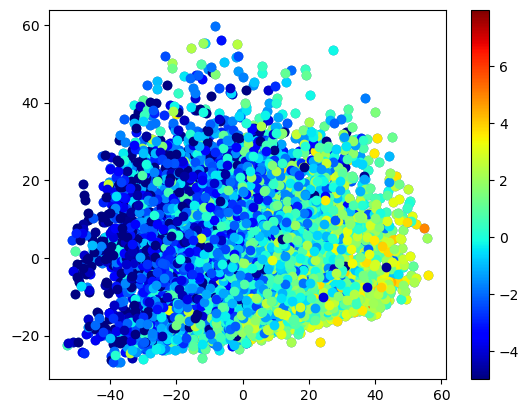

In [50]:
plt.plot(pca_vecs[:, 0], pca_vecs[:, 1], 'o')
# change color based on logP with jitter
colors = plt.cm.jet(target / np.max(target))
for i in range(len(pca_vecs)):
    plt.plot(pca_vecs[i, 0], pca_vecs[i, 1], 'o', color=colors[i])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(target), vmax=np.max(target)))
sm._A = []
plt.colorbar(sm)

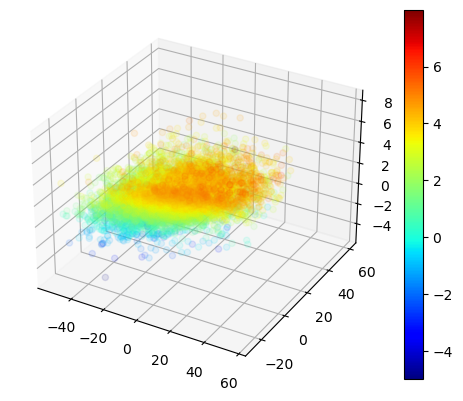

In [51]:
# 3d plot with logP as 3rd dimension
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_vecs[:, 0], pca_vecs[:, 1], target, c=target, cmap=plt.cm.jet, marker='o', alpha = 0.1)
# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=np.min(target), vmax=np.max(target)))
sm._A = []
plt.colorbar(sm)

In [52]:
CALLS = []
def get_score(id):
    global CALLS
    CALLS.append(id)
    return target[id]

In [53]:
import torch
def parabola(x):
    return torch.sum(x**2 + 7 * x + 3)

In [54]:
# optimize parabola
test_X = torch.tensor([0.0, 0.0], requires_grad=True)
for i in range(100):
    grad = torch.autograd.grad(parabola(test_X), test_X)[0]
    step = 0.1
    test_X = test_X - step * grad
    print(f'Iteration {i+1}: {test_X}')
    print(f'f(x) = {parabola(test_X)}')

Iteration 1: tensor([-0.7000, -0.7000], grad_fn=<SubBackward0>)
f(x) = -2.820000648498535
Iteration 2: tensor([-1.2600, -1.2600], grad_fn=<SubBackward0>)
f(x) = -8.464799880981445
Iteration 3: tensor([-1.7080, -1.7080], grad_fn=<SubBackward0>)
f(x) = -12.077470779418945
Iteration 4: tensor([-2.0664, -2.0664], grad_fn=<SubBackward0>)
f(x) = -14.389581680297852
Iteration 5: tensor([-2.3531, -2.3531], grad_fn=<SubBackward0>)
f(x) = -15.869331359863281
Iteration 6: tensor([-2.5825, -2.5825], grad_fn=<SubBackward0>)
f(x) = -16.81637191772461
Iteration 7: tensor([-2.7660, -2.7660], grad_fn=<SubBackward0>)
f(x) = -17.42247772216797
Iteration 8: tensor([-2.9128, -2.9128], grad_fn=<SubBackward0>)
f(x) = -17.81038475036621
Iteration 9: tensor([-3.0302, -3.0302], grad_fn=<SubBackward0>)
f(x) = -18.05864906311035
Iteration 10: tensor([-3.1242, -3.1242], grad_fn=<SubBackward0>)
f(x) = -18.217533111572266
Iteration 11: tensor([-3.1994, -3.1994], grad_fn=<SubBackward0>)
f(x) = -18.31922149658203
Iter

In [55]:
test_vecs = vecs.drop(['logP', 'smiles'], axis=1)

In [56]:
def f(X, nn_clf):
    # get neighbors
    X_numpy = X.detach().numpy()
    neighbors = nn_clf.kneighbors([X_numpy], return_distance=False)[0]
    # get score of neighbors
    scores = torch.tensor([get_score(i) for i in neighbors], dtype=torch.float, requires_grad=True)
    # get coordinates of neighbors
    coords = torch.tensor([test_vecs.iloc[i].values for i in neighbors], dtype=torch.float, requires_grad=True)
    # f(x) = distance weighted average of neighbors
    # distance weighted average = sum of scores * (1 / distance)
    # distance = euclidean distance
    distance_sum = torch.sum(1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)))
    scores = torch.sum(scores * (1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)))) / distance_sum
    return torch.mean(scores)



In [57]:
from utils import *
global_seed(654)

Global seed set to 654


In [58]:
# 300 dim vector
X = torch.randn(300)

In [59]:
f(X, nbrs)

tensor(1.7159, grad_fn=<MeanBackward0>)

In [60]:
# optimize f(x)
X = torch.randn(300, requires_grad=True)

In [61]:
from torch.optim import Adam
optimizer = Adam([X], lr=0.0001)

In [62]:
CALLS = []
for i in range(10000):
    optimizer.zero_grad()
    loss = f(X, nbrs)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
        print(f'Iteration {i}: {f(X, nbrs)}')

Iteration 0: 1.7520672082901
Iteration 500: 1.7478567361831665
Iteration 1000: 1.7436416149139404
Iteration 1500: 1.7394171953201294
Iteration 2000: 1.7351810932159424
Iteration 2500: 1.7309330701828003
Iteration 3000: 1.726676106452942
Iteration 3500: 1.7224125862121582
Iteration 4000: 1.7181439399719238
Iteration 4500: 1.4258252382278442
Iteration 5000: 1.3396531343460083
Iteration 5500: 1.338711142539978
Iteration 6000: 1.6793338060379028
Iteration 6500: 1.6772316694259644
Iteration 7000: 1.4195165634155273
Iteration 7500: 1.4180482625961304
Iteration 8000: 1.3331151008605957
Iteration 8500: 1.3318321704864502
Iteration 9000: 1.330500602722168
Iteration 9500: 1.3291220664978027


In [63]:
print(f'Visited {len(set(CALLS))} points')

Visited 7 points


In [67]:
lrs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [68]:
for lr in lrs:
    print(f'Learning rate: {lr}')
    global_seed(650)
    X = torch.randn(300, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in range(10000):
        optimizer.zero_grad()
        loss = f(X, nbrs)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iteration {i}: {f(X, nbrs)}')
            lrs_timeline[lr].append(f(X, nbrs).item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(len(set(CALLS)))

Learning rate: 0.001
Global seed set to 650
Iteration 0: 1.7054604291915894
Iteration 100: 1.6967052221298218
Iteration 200: 1.6879926919937134
Iteration 300: 1.679275393486023
Iteration 400: 1.3359078168869019
Iteration 500: 1.3338439464569092
Iteration 600: 1.331728458404541
Iteration 700: 1.3295127153396606
Iteration 800: 1.3271727561950684
Iteration 900: 1.3246910572052002
Iteration 1000: 1.3220490217208862
Iteration 1100: 1.3192085027694702
Iteration 1200: 1.3161143064498901
Iteration 1300: 1.3127740621566772
Iteration 1400: 1.3091470003128052
Iteration 1500: 1.3814133405685425
Iteration 1600: 1.4543311595916748
Iteration 1700: 1.295851230621338
Iteration 1800: 1.3632317781448364
Iteration 1900: 1.4299498796463013
Iteration 2000: 1.3466798067092896
Iteration 2100: 1.4073575735092163
Iteration 2200: 1.324694037437439
Iteration 2300: 1.3111432790756226
Iteration 2400: 1.2955728769302368
Iteration 2500: 1.3396974802017212
Iteration 2600: 1.2581626176834106
Iteration 2700: 1.236734628

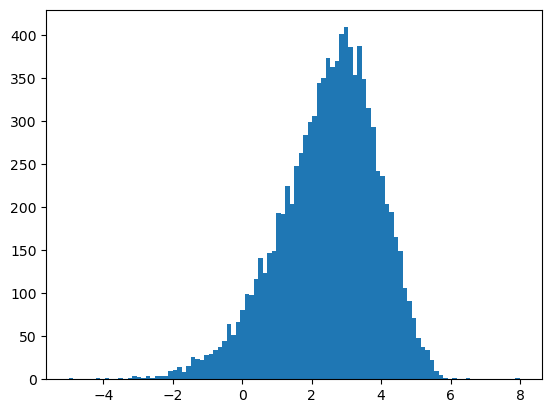

In [69]:
# plot learning rate vs exploration index
_ = plt.hist(vecs['logP'], bins=100)

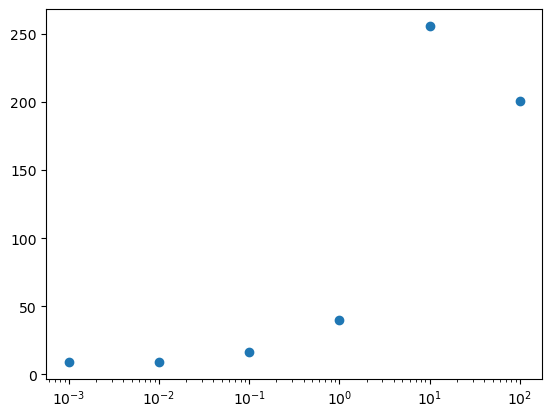

In [70]:
# plot learning rate vs exploration index plot in log scale
_ = plt.plot(lrs, exploration_index, 'o')
plt.xscale('log')

In [72]:
for lr in lrs:
    print(f'Best logP for lr={lr}: {np.min(lrs_timeline[lr])}')

Best logP for lr=0.001: 0.7648655772209167
Best logP for lr=0.01: 0.7652924656867981
Best logP for lr=0.1: -1.1461920738220215
Best logP for lr=1.0: -1.1242316961288452
Best logP for lr=10.0: -3.740234851837158
Best logP for lr=100.0: -3.3659591674804688


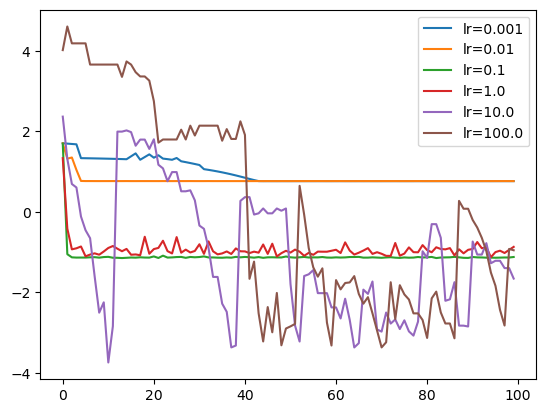

In [73]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [74]:
from scipy import stats

In [76]:
#percentile of each best logP
for lr in lrs:
    print(f'Percentile of best logP for lr={lr}: {stats.percentileofscore(vecs["logP"], np.min(lrs_timeline[lr]))}')

Percentile of best logP for lr=0.001: 12.280000000000001
Percentile of best logP for lr=0.01: 12.280000000000001
Percentile of best logP for lr=0.1: 1.56
Percentile of best logP for lr=1.0: 1.61
Percentile of best logP for lr=10.0: 0.03
Percentile of best logP for lr=100.0: 0.04
